#Putting it all together

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def generate_mesh_square(node_count, length, mesh_type='quad', fixed_node_option='all'):
    """
    Generate a square mesh with specified properties.

    Parameters:
        node_count (int): Number of nodes per side (>= 2).
        length (float): Total length of the square side (> 0).
        mesh_type (str): 'quad' for quadrilateral, 'tri' for triangular, or 'tri_both' for both diagonals in each quad.
        fixed_node_option (str): Controls fixed nodes:
            'all' - All edge nodes fixed.
            'everyOther' - Every other edge node fixed.
            'none' - No nodes fixed.

    Returns:
        verts (numpy.ndarray): Nodal coordinates (n x 3 array).
        edges (numpy.ndarray): Connectivity matrix (m x 2 array).
        fixed (numpy.ndarray): Fixed nodes (p x 3 array).
        fixed_indices (numpy.ndarray): Indices of fixed nodes.
        midlines (dict): Indices for horizontal and vertical midlines.
        diagonals (dict): Indices for main and anti-diagonals.
    """
    # Input validation
    if node_count < 2:
        raise ValueError("node_count must be at least 2.")
    if length <= 0:
        raise ValueError("length must be greater than 0.")
    if mesh_type not in {'quad', 'tri', 'tri_both'}:
        raise ValueError('mesh_type must be "quad", "tri", or "tri_both".')
    if fixed_node_option not in {'all', 'everyOther', 'none'}:
        raise ValueError('fixed_node_option must be "all", "everyOther", or "none".')

    # Step 1: Create nodes
    spacing = length / (node_count - 1)
    x, y = np.meshgrid(np.linspace(0, length, node_count), np.linspace(0, length, node_count))
    verts = np.column_stack((x.ravel(), y.ravel(), np.zeros(node_count**2)))  # All nodes in the z=0 plane initially

    # Step 2: Define connectivity
    edges = []
    for i in range(node_count - 1):
        for j in range(node_count - 1):
            # Get indices of the current square's corners
            n1 = i * node_count + j
            n2 = n1 + 1
            n3 = n1 + node_count
            n4 = n3 + 1

            if mesh_type == 'quad':
                # Quadrilateral connectivity
                edges.extend([(n1, n2), (n2, n4), (n4, n3), (n3, n1)])
            elif mesh_type == 'tri':
                # Triangular connectivity
                edges.extend([(n1, n2), (n2, n4), (n4, n1), (n1, n3), (n3, n4)])
            elif mesh_type == 'tri_both':
                # Triangular connectivity (both diagonals per quad)
                edges.extend([(n1, n2), (n2, n4), (n4, n1)])  # Triangle 1
                edges.extend([(n2, n3), (n3, n4), (n4, n2)])  # Triangle 2

    # Remove duplicate edges
    edges = np.unique(np.sort(edges, axis=1), axis=0)

    # Step 3: Determine fixed nodes
    edge_indices = np.unique(
        np.concatenate([
            np.arange(node_count),  # Bottom edge
            np.arange(node_count - 1, node_count**2, node_count),  # Right edge
            np.arange(node_count**2 - 1, node_count**2 - node_count - 1, -1),  # Top edge
            np.arange(node_count**2 - node_count, -1, -node_count)  # Left edge
        ])
    )

    if fixed_node_option == 'all':
        fixed_indices = edge_indices
    elif fixed_node_option == 'everyOther':
        fixed_indices = edge_indices[::2]
    else:  # 'none'
        fixed_indices = np.array([], dtype=int)
    
    fixed = verts[fixed_indices]

    # Step 4: Identify midlines and diagonals
    midlines = {
        'horizontal': np.where(np.abs(verts[:, 1] - length / 2) < spacing / 2)[0],
        'vertical': np.where(np.abs(verts[:, 0] - length / 2) < spacing / 2)[0]
    }

    diagonals = {
        'main': np.where(np.abs(verts[:, 0] - verts[:, 1]) < spacing / 2)[0],
        'anti': np.where(np.abs(verts[:, 0] + verts[:, 1] - length) < spacing / 2)[0]
    }

    return verts, edges, fixed, fixed_indices, midlines, diagonals



def apply_shape_function(verts, lines, shape_function, max_height, plot_option=False):
    """
    Applies a shape function to the vertices along specified lines.

    Parameters:
        verts (numpy.ndarray): Vertex coordinates (n x 3 array).
        lines (dict): Dictionary with diagonal indices or other line definitions.
        shape_function (str): Shape function ('pyramid', 'gaussian', 'sinusoidal').
        max_height (float): Maximum height for the shape function.
        plot_option (bool): If True, plot before and after the transformation.

    Returns:
        updated_verts (numpy.ndarray): Modified vertex coordinates (n x 3 array).
        new_fixed_indices (numpy.ndarray): Indices of updated vertices.
    """
    # Validate shape function
    valid_shapes = {'pyramid', 'gaussian', 'sinusoidal'}
    if shape_function not in valid_shapes:
        raise ValueError(f"Invalid shape function. Choose from {valid_shapes}.")

    # Combine all line indices into a single list
    line_indices = np.unique(np.concatenate([lines[key] for key in lines]))

    new_fixed_indices = line_indices

    # Extract vertices corresponding to the line indices
    line_verts = verts[line_indices]

    # Calculate distances from the line's center for each vertex
    line_center = np.mean(line_verts[:, :2], axis=0)  # Center in the x-y plane
    distances = np.linalg.norm(line_verts[:, :2] - line_center, axis=1)

    # Normalize distances to [0, 1]
    max_distance = np.max(distances)
    normalized_distances = distances / max_distance

    # Compute new z values based on the selected shape function
    if shape_function == 'pyramid':
        # Linear height distribution (inverted V shape)
        new_z = max_height * (1 - normalized_distances)
    elif shape_function == 'gaussian':
        # Gaussian curve
        new_z = max_height * np.exp(-4 * (normalized_distances ** 2))
    elif shape_function == 'sinusoidal':
        # Half sinusoidal wave (arch-like shape)
        new_z = max_height * (np.sin(np.pi * (1 - normalized_distances) / 2) ** 2)
    else:
        raise ValueError("Unsupported shape function.")

    # Assign new z values to the vertices
    updated_verts = verts.copy()
    updated_verts[line_indices, 2] = new_z

    # Plot before and after if plot_option is enabled
    if plot_option:
        fig = plt.figure(figsize=(12, 6))

        # Original vertices
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c='b', s=20, label="Original free nodes")
        ax1.scatter(line_verts[:, 0], line_verts[:, 1], line_verts[:, 2], c='r', s=50, label="Original fixed nodes")
        ax1.set_title("Original Mesh")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")
        ax1.set_zlabel("Z")
        ax1.grid(True)
        ax1.legend()
        ax1.view_init(elev=20, azim=30)

        # Updated vertices
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(updated_verts[:, 0], updated_verts[:, 1], updated_verts[:, 2], c='b', s=20, label="Updated free nodes (unchanged)")
        ax2.scatter(updated_verts[line_indices, 0], updated_verts[line_indices, 1], updated_verts[line_indices, 2],
                    c='r', s=50, label="Updated fixed nodes (changed)")
        ax2.set_title(f"Mesh After Applying {shape_function.capitalize()} Shape")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")
        ax2.set_zlabel("Z")
        ax2.grid(True)
        ax2.legend()
        ax2.view_init(elev=20, azim=30)

        plt.tight_layout()
        plt.show()

    return updated_verts, new_fixed_indices



def dynamic_relaxation(params, xyz, edges, free_indices, fixed, applied_link_force):
    """
    Perform dynamic relaxation to find the equilibrium state of a structure.
    Returns:
        LinkTension, xyz, KEAllStore, edges, history
    """

    # Extract parameters
    dt = params['dt']
    area = params['Area']
    E_elastic = params['Elastic']
    restlengthOG = params['restlengthOG']
    tolerance = params['tolerance']
    max_iterations = params['MaximumIterations']
    applied_constant_force = params['ConstantForce']

    # Initialize variables
    vertex_count = xyz.shape[0]
    edge_count = edges.shape[0]
    K_S = (E_elastic * area) / restlengthOG  # Initial geometric stiffness
    #print('KS is:', K_S)
    #print('restlengthOG is:', restlengthOG)

    v = np.zeros((vertex_count, 3))  # Initializing velocities
    S = np.zeros((vertex_count, 3))  # Forces on nodes
    R = np.zeros((vertex_count, 3))  # Residual forces
    KE = 0  # Initial kinetic energy
    reset_flag = False

    # Initialize history
    history = {
        "xyz": [],
        "v": [],
        "KE": [],
        "m": [],
        "iters": 0,
    }

    # Main loop variables
    t = 1
    difference = np.inf
    KE_store = []

    while difference > tolerance and t <= max_iterations:
        # Step 1: Initialization
        vp = np.copy(v)  # Store previous velocities
        xyz0 = np.copy(xyz)  # Store previous positions
        KE_0 = KE  # Store previous kinetic energy

        # Step 2: Compute Link Lengths and Forces
        link_vectors_t = xyz[edges[:, 1]] - xyz[edges[:, 0]]
        link_lengths_t = np.linalg.norm(link_vectors_t, axis=1, keepdims=True)
        #print(link_lengths_t)

        link_tension = np.full_like(link_lengths_t, applied_constant_force[2])  # Initialize constant link tension
        link_tension += K_S * (link_lengths_t - restlengthOG)
        link_tension[link_tension < 0] = 0  # No compression allowed

        # Step 3: Node-Specific Mass Computation #
        m = np.zeros(vertex_count)
        geom_stiffness = link_tension / link_lengths_t
        #print(geom_stiffness)
        for node in range(vertex_count):
            adjoining_edges = np.sum(edges == node, axis=1)
            #print(adjoining_edges)
            adjoining_edges = adjoining_edges[:, np.newaxis] 
            stiffness = np.sum((K_S / restlengthOG) * adjoining_edges + geom_stiffness * adjoining_edges)
            #print('stiffness', stiffness)
            #print(K_S.shape, restlengthOG.shape, geom_stiffness.shape, adjoining_edges.shape)
            m[node] = stiffness
        

        # Step 4/5: Force Resolution
        edge_force_s = np.zeros((edge_count, 3))
        for i in range(edge_count):
            edge_force_s[i] = (link_vectors_t[i] / link_lengths_t[i]) * link_tension[i]
            S[edges[i, 0]] += edge_force_s[i]
            S[edges[i, 1]] -= edge_force_s[i]

        R[free_indices] = applied_link_force[free_indices] + S[free_indices]

        # Step 6: Update Velocities and Positions
        A = 1  # Damping constant
        B = (dt / m[:, None])

        v[free_indices] = A * vp[free_indices] + B[free_indices] * R[free_indices]
        xyz[free_indices] = xyz0[free_indices] + dt * v[free_indices]

        KE = np.sum(0.5 * m * np.linalg.norm(v, axis=1)**2)
        KE_store.append(KE)

        # Step 7/8: Kinetic Energy Correction
        if t > 2 and not reset_flag and KE > KE_0:
            E = KE_store[-2] - KE_store[-1]
            D = KE_store[-3] - KE_store[-2]
            q = max(0, min(E / (E - D), 1))  # Clamp q between 0 and 1

            R_t = m[:, None] * (v - vp) / dt
            xyz -= (dt * (1 + q) * vp) + (dt**2 / 2) * q * (R_t / m[:, None])

            # Reset variables
            KE = 0
            v = np.zeros((vertex_count, 3))
            R = np.zeros((vertex_count, 3))
            S = np.zeros((vertex_count, 3))
            reset_flag = True
        else:
            reset_flag = False

        # Step 9: Convergence Check
        difference = np.linalg.norm(xyz - xyz0, ord='fro')
        history["xyz"].append(np.copy(xyz))
        history["v"].append(np.copy(v))
        history["KE"].append(KE)
        history["m"].append(m)

        t += 1

    history["iters"] = t - 1
    return link_tension, xyz, KE_store, edges, history



def plot_geometry(xyz, edges, fixed, titlePlot = str):
    """
    Plot geometry in 3D.

    Parameters:
    - xyz: np.array of shape (N, 3), node coordinates.
    - edges: np.array of shape (M, 2), indices of edges connecting nodes.
    - fixed: np.array of shape (P, 3), coordinates of fixed nodes.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot edges
    for edge in edges:
        x_vals = [xyz[edge[0], 0], xyz[edge[1], 0]]
        y_vals = [xyz[edge[0], 1], xyz[edge[1], 1]]
        z_vals = [xyz[edge[0], 2], xyz[edge[1], 2]]
        ax.plot(x_vals, y_vals, z_vals, 'b')  # Blue lines for edges
    
    
    # Plot free nodes
    #ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='k', marker='o', label='Nodes')
    
    # Plot fixed nodes
    ax.scatter(fixed[:, 0], fixed[:, 1], fixed[:, 2], c='r', marker='*', label='Fixed Nodes')


    
    # Labels, title, and grid
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(titlePlot)
    ax.legend()
    ax.grid(True)
    ax.set_box_aspect([1, 1, 1])  # Equal scaling
    
    plt.show()


# Running it 

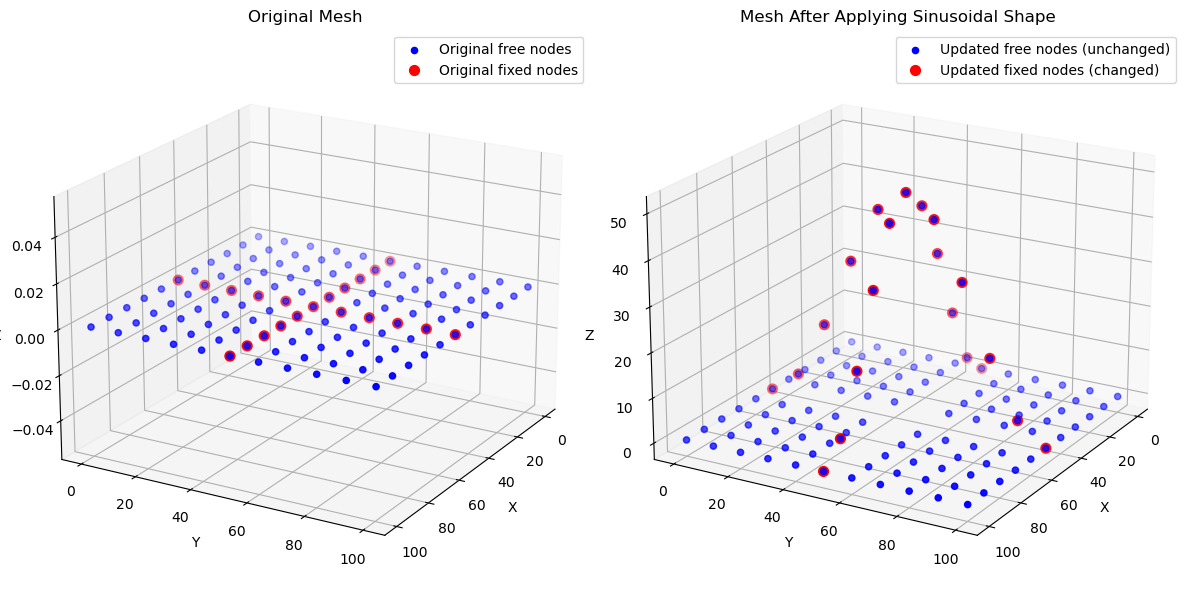

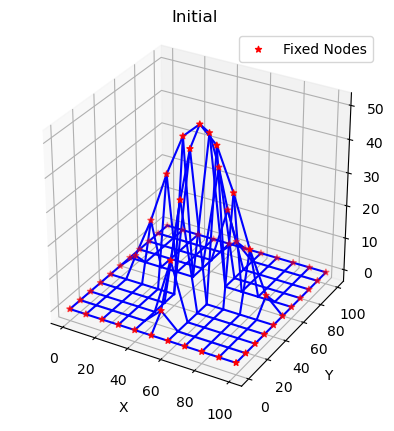

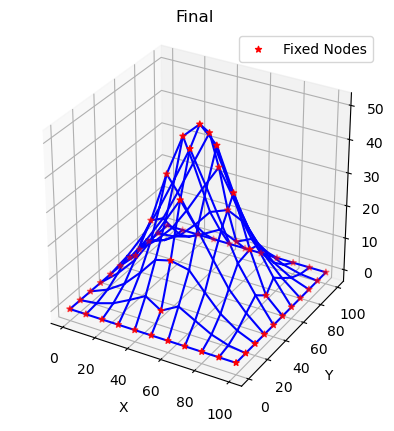

In [53]:
node_count= 11
node_length= 100
mesh_type = 'quad'
fixed_node_option = 'all'

verts, edges, fixed, fixed_indices, midlines, diagonals = generate_mesh_square(node_count,node_length,mesh_type,fixed_node_option)

#get rest lengths here
edge_vectors = verts[edges[:, 1]] - verts[edges[:, 0]]
rest_lengths = np.linalg.norm(edge_vectors, axis=1, keepdims=True)  # rest lengths of edges
#print(rest_lengths)

shape_function = 'sinusoidal'
max_height = 50
verts, new_fixed_indices = apply_shape_function(verts, midlines, shape_function, max_height, plot_option=True)
#fixed = verts[new_fixed_indices,:]


AllFixedIndices = np.unique(np.hstack((fixed_indices,new_fixed_indices)))
AllIndices = (np.arange(len(verts)))
AllFreeIndices = np.array(list((set(AllIndices) | set(AllFixedIndices)) - (set(AllIndices) & set(AllFixedIndices))))
#print(AllFreeIndices)
vertexCount = len(verts)
#print(vertexCount)
AppliedLinkForce = np.zeros((vertexCount, 3))
AllFixed = verts[AllFixedIndices]

# DR params
params = {
    'MaximumIterations': 150,
    'tolerance': 5e-1,
    'dt': 0.49,  # Time interval
    'm': 1,  # Fictitious mass
    'Elastic': 1000,  # Elastic modulus (MPa)
    'Area': (0.1**2) * np.pi,  # Cross-sectional area (note: use ** for exponentiation)
    'ConstantForce': [0, 0, 0],  # External forces
    'meshType': 'triangular_prismatic',  # Mesh type
    'length_threshold': 0.5,  # Threshold for long edges
    'restlengthOG': rest_lengths,
}

# Initial geoemtry
plot_geometry(verts, edges, AllFixed,'Initial')

LinkTension, xyz, KEAllStore, edges, history = dynamic_relaxation(params,verts, edges, AllFreeIndices, AllFixed, AppliedLinkForce)

# final geoemtry
plot_geometry(xyz, edges, AllFixed,'Final')

In [46]:
#exploring

history


{'xyz': [array([[  0.        ,   0.        ,   0.91578194],
         [ 11.11111111,   0.        ,   0.        ],
         [ 22.22222222,   0.        ,   0.        ],
         [ 33.33333333,   0.        ,   0.        ],
         [ 44.44444444,   0.        ,   0.        ],
         [ 55.55555556,   0.        ,   0.        ],
         [ 66.66666667,   0.        ,   0.        ],
         [ 77.77777778,   0.        ,   0.        ],
         [ 88.88888889,   0.        ,   0.        ],
         [100.        ,   0.        ,   0.91578194],
         [  0.        ,  11.11111111,   0.        ],
         [ 11.11111111,  11.11111111,   4.44717881],
         [ 21.99058057,  12.38260292,   1.75750594],
         [ 33.33333333,  11.11111111,   0.        ],
         [ 44.44444444,  11.11111111,   0.        ],
         [ 55.55555556,  11.11111111,   0.        ],
         [ 66.66666667,  11.11111111,   0.        ],
         [ 78.00941943,  12.38260292,   1.75750594],
         [ 88.88888889,  11.11111111,  

In [ ]:
print(np.zeros(vertexCount))